# Packages

In [2]:
import os
import sys
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
sys.path.insert(0, '..')
import torchattacks
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
device = "cuda"

/home/adl/anaconda3/envs/zenn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset

### Load images

In [3]:
import os
from PIL import Image
from torchvision import transforms

eval500_folder = "/home/adl/Desktop/zenn/SPML/SPML_HW1/cifar-100_eval/"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
tensor_images = []
file_names = []
for filename in os.listdir(eval500_folder):
    if filename.endswith('.png'):  
        image_path = os.path.join(eval500_folder, filename)
        image = Image.open(image_path).convert('RGB')  
        tensor_image = transform(image).to(device)  
        tensor_images.append(tensor_image)  
        file_names+=[filename]
        

Files already downloaded and verified


### Load labels

In [ ]:
eval_labels = []
eval_labels_loaded = np.load('/home/adl/Desktop/zenn/SPML/SPML_HW1/labels.npy')
for i in range(len(eval_labels_loaded)):
    eval_labels.append(torch.tensor(eval_labels_loaded[i]).to(device))
print(eval_labels)

# Models

In [33]:
model_names = ["repvgg_a2"] #resnet56","vgg19_bn","mobilenetv2_x1_4","shufflenetv2_x2_0","
models = []
for name,i in zip(model_names,range(len(model_names))):
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", f"cifar100_{name}", pretrained=True)
    model = model.cuda()  # Move the model to GPU
    model.eval()  
    models.append(model)
    print(f"model{i+1}:{name}___")

Using cache found in /home/adl/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


model1:repvgg_a2___


# Utility functions

### Denormalize function

In [23]:
def denorm(batch, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

### Get Cifar-100 calsses

In [24]:
cifar100_classes = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

def get_cifar100_class(class_number):
    if class_number >= 0 and class_number < len(cifar100_classes):
        return cifar100_classes[class_number]
    else:
        return "Invalid class number"

### Attack mothods

In [26]:
def get_attack(attack,model,eps):
    fgsm = torchattacks.FGSM(model, eps=eps)
    fgsm.set_normalization_used(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    pgd = torchattacks.PGD(model, eps=eps, alpha=2/255, random_start=True)
    pgd.set_normalization_used(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    strongAtk = torchattacks.MultiAttack([pgd, fgsm])
    strongAtk.set_normalization_used(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    if attack == "FGSM":
        return fgsm
    elif attack == "PGD":
        return pgd
    elif attack == "Combined":
        return strongAtk

### Epsilon test set

In [27]:
def get_eps(eps):
    epsilons0 = [8/256]
    epsilons1 = [0/256,2/256,4/256,6/256,8/256]
    epsilons2 = [0/256,1/256,2/256,3/256,4/256,5/256,6/256,7/256,8/256 ]
    if eps == 0: return epsilons0
    elif eps == 1: return epsilons1
    elif eps == 2: return epsilons2
    else: return [0/256]

### Attack and Calculate accuracy

In [32]:
def calculate_accuracy(source_model,atk,eps):
       corrects = [0]*len(models)
       total = 0
       adv_examples = []
       adv_preds = []
       attack = get_attack(atk,source_model,eps)
       print(f"{atk} attack (epsilon={eps})")
       accuracies = []
       for images,labels in zip(tensor_images,eval_labels):
              images, labels = images.to(device), labels.to(device)  # Move data to the same device as the model)
              images.requires_grad = True   
              adv_images = attack(images, labels)
              adv_images = adv_images.to(device)
              total += labels.size(0)
              
              for model,i in zip(models,range(len(models))):
                     outputs = model(adv_images)
                     _, predicted = torch.max(outputs.data, 1)
                     if(eps == 8/256):
                            adv_examples += adv_images
                            adv_preds+= predicted
                     corrects[i] += (predicted == labels).sum().item()
                     
       for correct,i in zip(corrects,range(len(corrects))):
              accuracy = 100*correct/total
              accuracies.append(accuracy)
              print(f"Accuracies of {atk} attack on {model_names[i]} (epsilon:{eps}) : {accuracy} %")
       print(f"---------------------------------------------------------------------------------------")
       return accuracies,adv_examples,adv_preds

# Do the attack and get adversarial examples and accuracies

In [59]:
attacks = ["PGD"] # ," FGSM / PGD / Combined
eps_set = 2
accuracies = []
adversarial_examples = []
adversarial_predictions = []
for source_model in models:
    accuracies_on_diffent_atk = []
    for atk in attacks:
        accuracies_on_diffent_eps = []
        for eps in get_eps(eps_set):
            accs,exs,preds = calculate_accuracy(source_model,atk,eps)
            accuracies_on_diffent_eps.append(accs)
            if eps == 8/256:
                adversarial_examples.append(exs)
                adversarial_predictions.append(preds)
        accuracies_on_diffent_atk.append(accuracies_on_diffent_eps)
    accuracies.append(accuracies_on_diffent_atk)       

PGD attack (epsilon=0.0)
Accuracies of PGD attack on repvgg_a2 (epsilon:0.0) : 94.4 %
---------------------------------------------------------------------------------------
PGD attack (epsilon=0.00390625)
Accuracies of PGD attack on repvgg_a2 (epsilon:0.00390625) : 43.0 %
---------------------------------------------------------------------------------------
PGD attack (epsilon=0.0078125)
Accuracies of PGD attack on repvgg_a2 (epsilon:0.0078125) : 8.0 %
---------------------------------------------------------------------------------------
PGD attack (epsilon=0.01171875)
Accuracies of PGD attack on repvgg_a2 (epsilon:0.01171875) : 2.0 %
---------------------------------------------------------------------------------------
PGD attack (epsilon=0.015625)
Accuracies of PGD attack on repvgg_a2 (epsilon:0.015625) : 0.4 %
---------------------------------------------------------------------------------------
PGD attack (epsilon=0.01953125)
Accuracies of PGD attack on repvgg_a2 (epsilon:0.01

# Show some adversarial examples

Total miss: 500


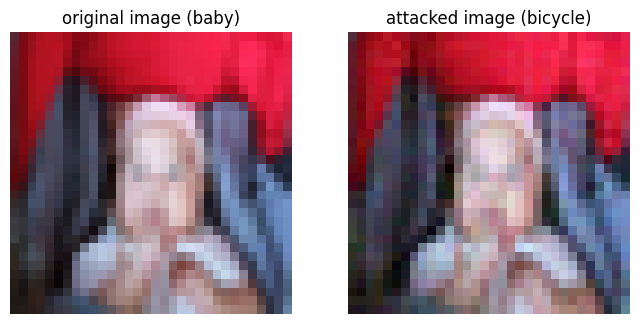

-----------------------------------------------------------------------------------------------


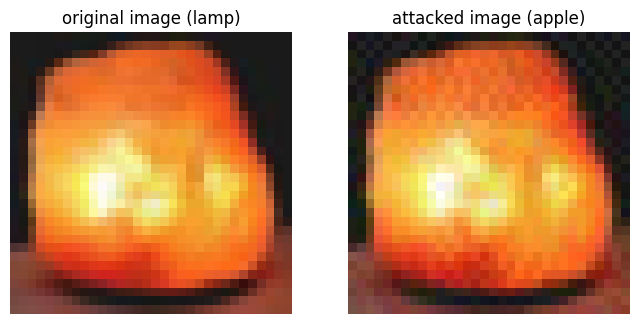

-----------------------------------------------------------------------------------------------


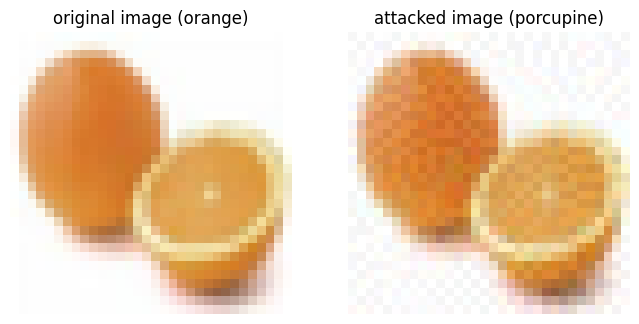

-----------------------------------------------------------------------------------------------


In [14]:
numOfSamples = 3
miss = 0
for i in range(0,len(tensor_images)):
    label = get_cifar100_class(int(eval_labels[i]))
    prediction = get_cifar100_class(int(adversarial_predictions[0][i]))
    if (label!=prediction):
        miss+=1
print('Total miss:',miss)     

numOfSamples = min(numOfSamples,miss)
random_numbers = np.random.randint(0, miss-1, numOfSamples)            
for i in random_numbers:
    label = get_cifar100_class(int(eval_labels[i]))
    prediction = get_cifar100_class(int(adversarial_predictions[0][i]))
    adv_images = denorm(adversarial_examples[0][i])
    perturbed_image = transforms.ToPILImage()(adv_images.squeeze())
    ori_images = denorm(tensor_images[i])
    img = transforms.ToPILImage()(ori_images.squeeze())
    plt.figure(figsize=(8,4)) 
    plt.subplot(121)   
    plt.title(f'original image ({label})')
    plt.imshow(img)
    plt.axis('off')  
    plt.subplot(122)   
    plt.title(f'attacked image ({prediction})')
    plt.imshow(perturbed_image)
    plt.axis('off')  
    plt.show()
    print("-----------------------------------------------------------------------------------------------")

    

# Data collecting

### Save adversarial examples

In [1]:
for i in range(500):
    label = get_cifar100_class(int(eval_labels[i]))
    prediction = get_cifar100_class(int(adversarial_predictions[0][i]))
    adv_images = denorm(adversarial_examples[0][i])
    perturbed_image = transforms.ToPILImage()(adv_images.squeeze())
    perturbed_image.save(f'/home/adl/Desktop/zenn/SPML/SPML_HW1/result/adv_imgs/{file_names[i]}', 'PNG')
    ori_images = denorm(tensor_images[i])
    img = transforms.ToPILImage()(ori_images.squeeze())
    plt.figure(figsize=(8,4)) 
    plt.subplot(121)   
    plt.title(f'original image ({label})')
    plt.imshow(img)
    plt.axis('off')  
    plt.subplot(122)   
    plt.title(f'attacked image ({prediction})')
    plt.imshow(perturbed_image)
    plt.axis('off')  
    plt.savefig(f"/home/adl/Desktop/zenn/SPML/SPML_HW1/result/imagePare/{file_names[i]}")

NameError: name 'get_cifar100_class' is not defined

### Save plots

[[94.4], [43.0], [8.0], [2.0], [0.4], [0.2], [0.0], [0.0], [0.0]]


<function matplotlib.pyplot.show(close=None, block=None)>

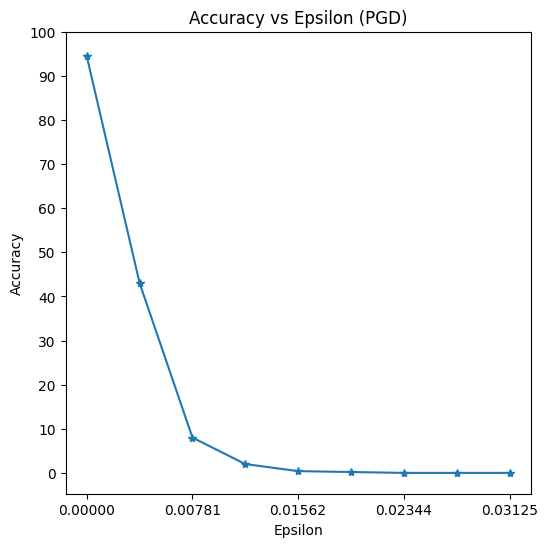

In [60]:
acc_for_plot = []
for acc in accuracies_on_diffent_eps:
        acc_for_plot.append(acc)
print(acc_for_plot)
eps_for_plot = get_eps(eps_set)
 # Save plt
plot_folder = "/home/adl/Desktop/zenn/SPML/SPML_HW1/result/AccVsEps"
plt.figure(figsize=(6,6))
plt.plot(eps_for_plot, acc_for_plot, "*-")
plt.yticks(np.arange(0, 105, step=10))
plt.xticks(np.arange(0, 10/256, step=2/256))
plt.title(f"Accuracy vs Epsilon ({attacks[0]})")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig(f"{plot_folder}/Accuracy_vs_Epsilon({attacks[0]}).png", dpi=300)
plt.show

[7.4, 19.0, 15.0, 19.6, 18.6]
[20.8, 17.4, 21.6, 25.0, 26.0]
[13.4, 17.4, 6.2, 17.0, 17.2]
[14.0, 19.0, 16.8, 7.2, 18.4]
[13.4, 17.2, 14.6, 18.2, 7.8]


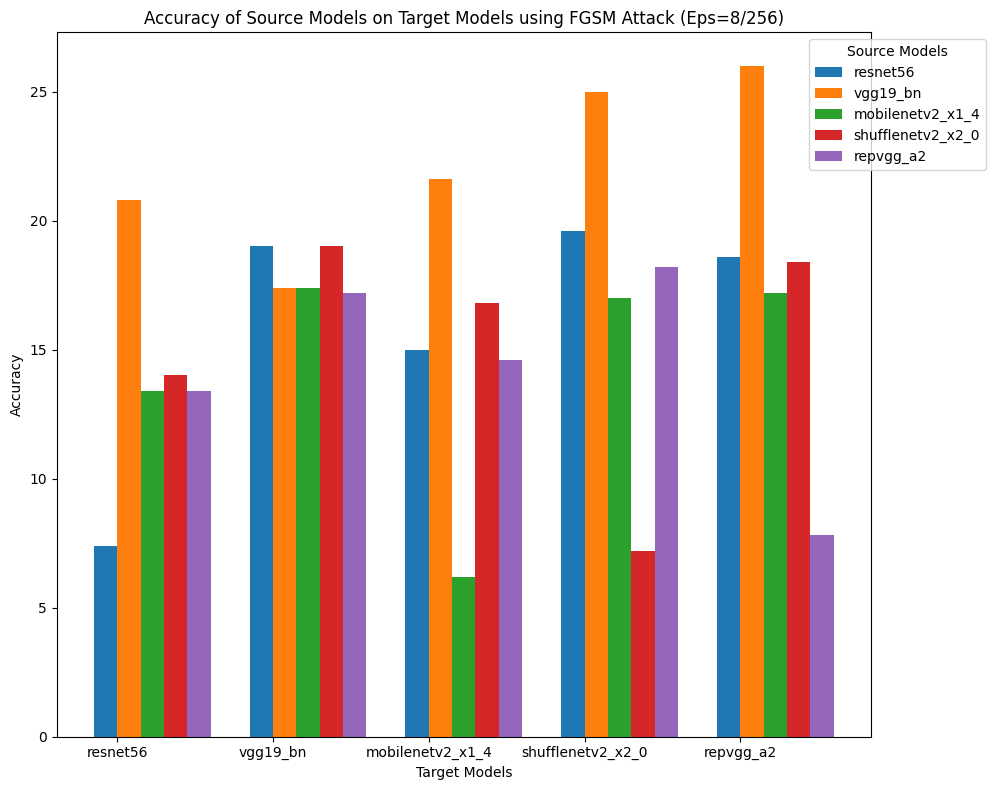

[0.0, 36.0, 16.6, 33.4, 27.6]
[17.4, 1.4, 19.8, 32.2, 30.8]
[11.6, 32.4, 0.0, 27.8, 23.2]
[8.6, 20.2, 6.8, 0.0, 18.6]
[6.8, 17.8, 6.6, 19.6, 0.0]


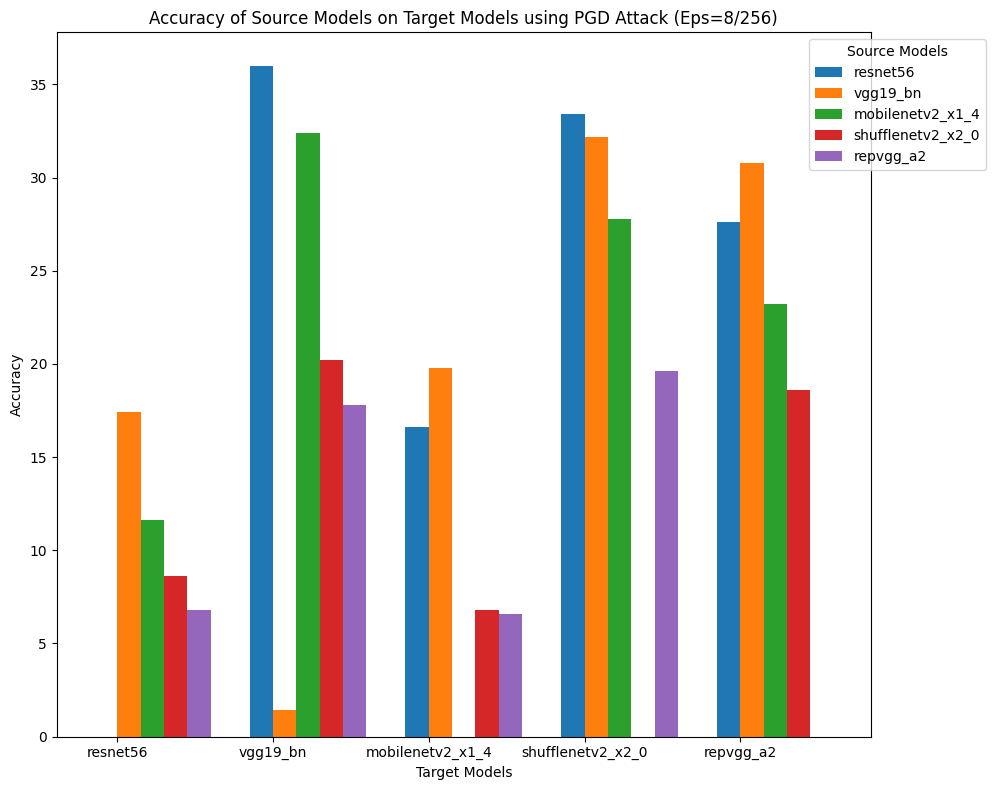

[0.0, 34.0, 16.4, 33.8, 26.2]
[17.8, 1.8, 21.0, 32.8, 31.4]
[11.6, 34.0, 0.0, 26.8, 23.8]
[11.4, 20.0, 8.0, 0.0, 17.0]
[6.6, 17.4, 6.6, 16.8, 0.0]


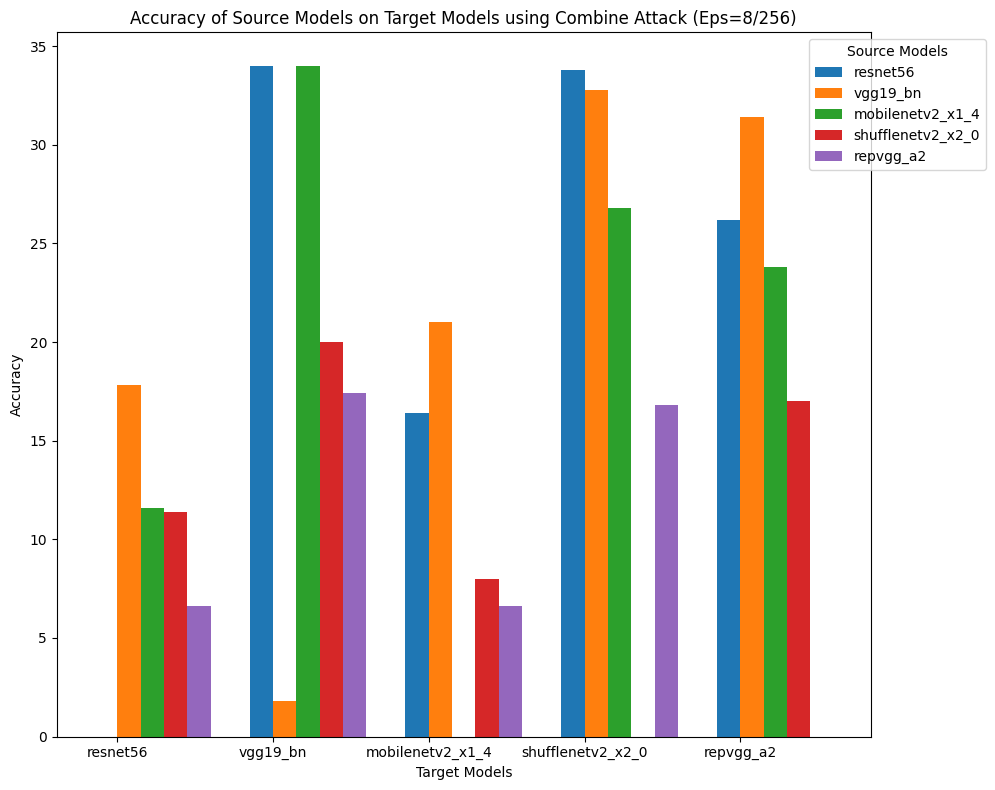

In [126]:
for atk1 in attacks:
    acc1 = []
    
    for source_model in model_names:
        print(accuracies[model_names.index(source_model)][attacks.index(atk1)][get_eps(eps_set).index(8/256)])
        acc1.append(accuracies[model_names.index(source_model)][attacks.index(atk1)][get_eps(eps_set).index(8/256)])

    acc1= np.array(acc1)

    source_model_labels = model_names
    target_model_labels = model_names

    plt.figure(figsize=(10, 8))

    num_source_models = len(source_model_labels)
    x = np.arange(len(target_model_labels))  # the label locations
    width = 0.15  # the width of the bars

    for i in range(num_source_models):
        plt.bar(x + i*width, acc1[i], width, label=source_model_labels[i])

    plt.xlabel('Target Models')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of Source Models on Target Models using {atk1} Attack (Eps=8/256)')
    plt.xticks(x + width / 2, target_model_labels)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Source Models")
    plt.tight_layout()
    plt.savefig(f"/home/adl/Desktop/zenn/SPML/SPML_HW1/result/AccVsEps/Accuracy_of_Source_Models_on_Target_Models_using_{atk1}_Attack.png",dpi=300)
    plt.show()
   
